In [9]:
%%capture
import sys
!{sys.executable} -m pip install --user scipy numpy matplotlib pandas

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', size=20)
matplotlib.rc('figure', figsize=(18, 10))

import numpy as np
import pandas as pd
from scipy import stats

_Which is more probable when rolling 2 six-sided dice: rolling snake eyes (two ones) or rolling sevens (dice sum to seven)? What is the ratio of the probabilities?_

Rolling a 6-sided die pulls data points from a multinomial distribution, where each side of the die has a $\frac{1}{6}$ probability of being rolled. To find the probability for snake eyes, we're looking to roll a 1 AND another 1, so that's $\frac{1}{6} \times \frac{1}{6} = \frac{1}{36}$. Easy enough. What about rolling sevens? We're looking to roll two numbers that add to 7. Let's make a table to show all the possibilities.

In [10]:
values = np.arange(1, 7)
table = np.zeros((6, 6))
for i in range(6):
    for j in range(6):
        table[i][j] = values[i] + values[j]
pd.DataFrame(table, columns=values, index=values)

,1,2,3,4,5,6
1,2.0,3.0,4.0,5.0,6.0,7.0
2,3.0,4.0,5.0,6.0,7.0,8.0
3,4.0,5.0,6.0,7.0,8.0,9.0
4,5.0,6.0,7.0,8.0,9.0,10.0
5,6.0,7.0,8.0,9.0,10.0,11.0
6,7.0,8.0,9.0,10.0,11.0,12.0


Because we can count 6 possible outcomes where the sum is seven, the probability to roll sevens is just $\frac{6}{36} = \frac{1}{6}$. The ratio of probabilities of rolling snake eyes to rolling sevens is thus $\frac{1}{36} \div \frac{1}{6} = \frac{1}{6}$. Thus rolling sevens is 6 times more probable than rolling snake eyes.

Let's use the convolution operation to numerically calculate the probability for any given sum of two dice rolls.

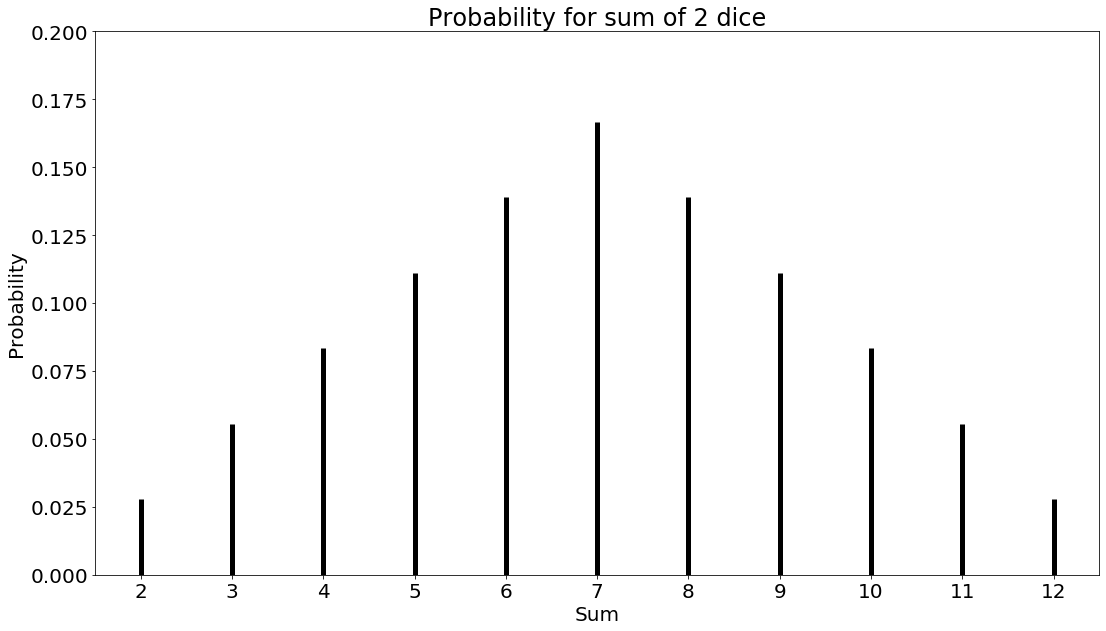

In [11]:
probs = np.array([1/6] * 6)
sum_probs = np.convolve(probs, probs)

plt.title("Probability for sum of 2 dice")
plt.xlabel("Sum")
plt.ylabel("Probability")
# The sum can range from 2 to 12
plt.xticks(range(2, 13))
plt.ylim(0, 0.2)
plt.vlines(range(2, 13), 0, sum_probs, linewidth=5);

The plot shows the probability of rolling sevens to be $\frac{1}{6}$, just as we found above.

What is the mean and variance of the above distribution? The mean is defined by the sum of all elements multiplied by their respective probabilities, and the variance is the sum of all the differences of each element from the mean, squared, multiplied by their probabilities.
In equations, $\mu = \sum\limits_{i=1}^{n} x_i p_i$ and $\sigma^2 = \sum\limits_{i=1}^{n} (x_i - \mu)^2 p_i$.

In [12]:
mean = sum(np.arange(2, 13) * sum_probs)
variance = sum((np.arange(2, 13) - mean)**2 * sum_probs)
print(f"mean: {mean}, variance: {variance}")

mean: 7.0, variance: 5.833333333333334


Now let's find the probability for the average of 10 independent die rolls. To average a distribution 10 times, we convolve it with itself 10 times.

In [13]:
def plot_avg_prob(trials, width=5):
    avg_probs = np.copy(probs)
    for i in range(trials):
        avg_probs = np.convolve(probs, avg_probs)

    plt.title(f"Probability for average of {trials} dice")
    plt.xlabel("Average")
    plt.ylabel("Probability")
    # The average can range from 1 to 6
    possible_avgs = np.linspace(1, 6, len(avg_probs))
    plt.vlines(possible_avgs, 0, avg_probs, linewidth=width);
    plt.xlim(1, 6)
    plt.ylim(0, None)
    return possible_avgs, avg_probs

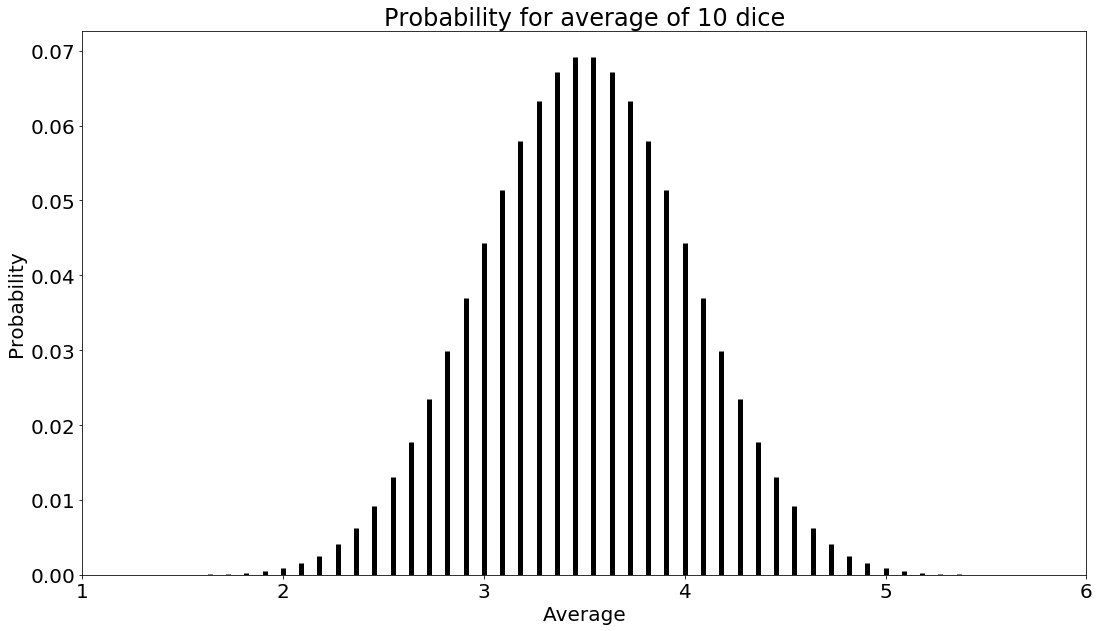

In [14]:
plot_avg_prob(10);

This distribution is beginning to look Gaussian. Note that it is not *exactly* Gaussian, but becomes a better approximation as the number of dice rolls increase. Let's examine the probabilities for 200 dice.

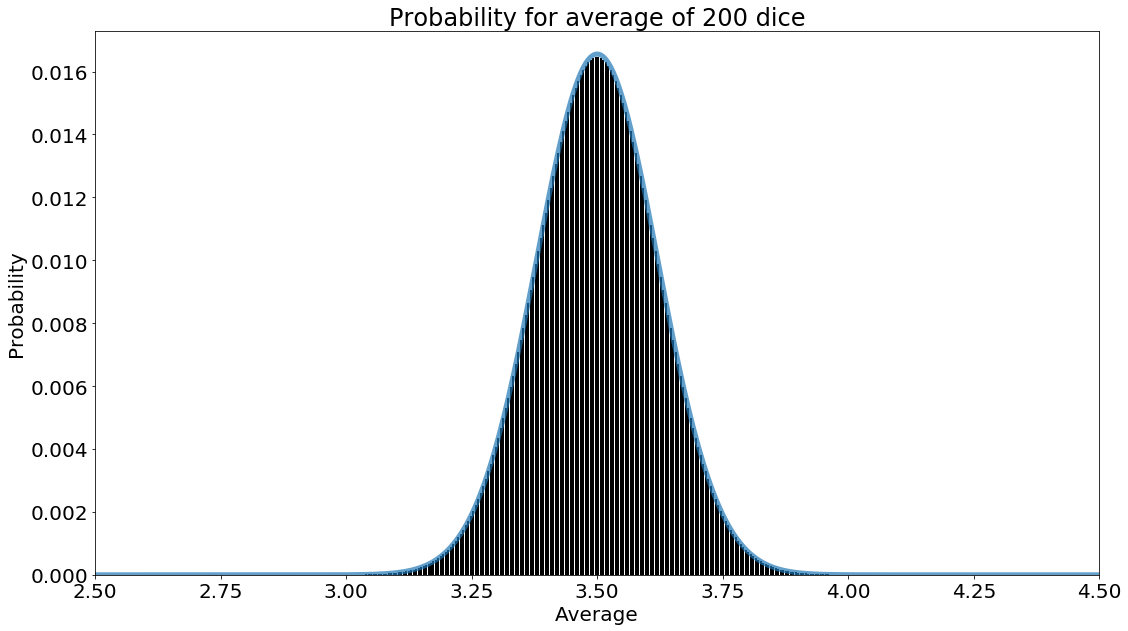

In [15]:
possible_avgs, avg_probs = plot_avg_prob(200, width=2)
mean = sum(possible_avgs * avg_probs)
variance = sum((possible_avgs - mean)**2 * avg_probs)

# Overlay Gaussian
ax = plt.gca()
plt.xlim(2.5, 4.5)
ax.plot(possible_avgs, stats.norm.pdf(possible_avgs, mean, np.sqrt(variance)) / 200, linewidth=5, alpha=0.7);

Notice how our probability distribution closely follows the blue Gaussian curve with the same mean and variance. Why does the approximation improve with a higher number of dice rolls? The answer lies in the central limit theorem, which states that _"in some situations, when independent random variables are added, their properly normalized sum tends toward a normal distribution (informally a "bell curve") even if the original variables themselves are not normally distributed."_ (Wikipedia)

How about the sum and convolution of a Gaussian with itself? Is that also Gaussian?

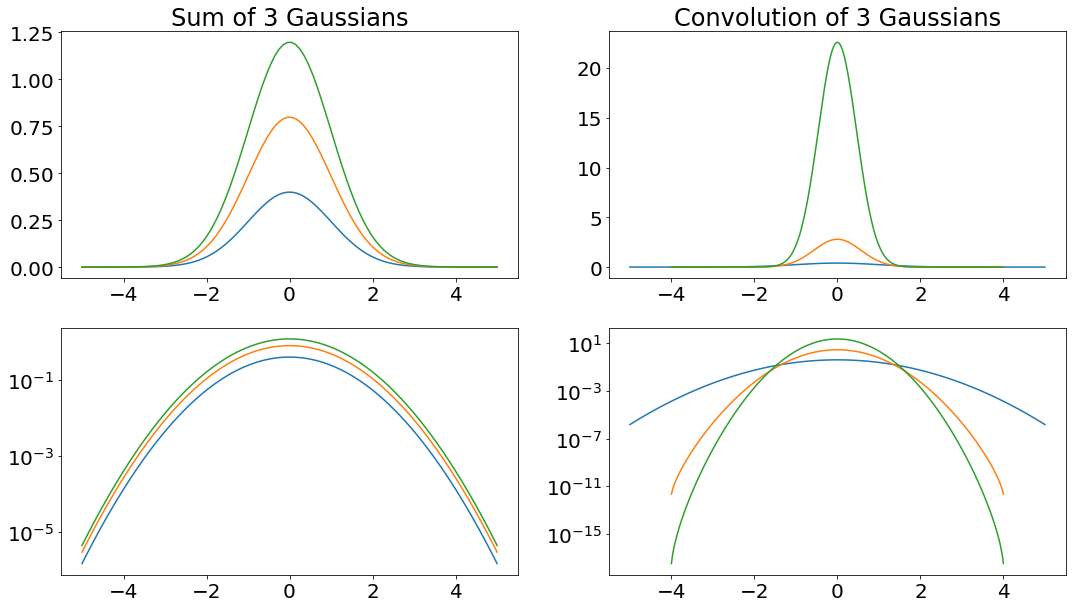

In [16]:
dist = stats.norm()
x = np.linspace(-5, 5, 100)

ax_1 = plt.subplot(2, 2, 1)
ax_1.set_title("Sum of 3 Gaussians")
ax_1.plot(x, dist.pdf(x))
ax_1.plot(x, dist.pdf(x) + dist.pdf(x))
ax_1.plot(x, dist.pdf(x) + dist.pdf(x) + dist.pdf(x))

ax_2 = plt.subplot(2, 2, 2)
ax_2.set_title("Convolution of 3 Gaussians")
ax_2.plot(x, dist.pdf(x))
avg = np.convolve(dist.pdf(x), dist.pdf(x))
avg_2 = np.convolve(avg, dist.pdf(x))
ax_2.plot(np.linspace(-4, 4, len(avg)), avg)
ax_2.plot(np.linspace(-4, 4, len(avg_2)), avg_2)

ax_3 = plt.subplot(2, 2, 3)
ax_3.semilogy(x, dist.pdf(x))
ax_3.semilogy(x, dist.pdf(x) + dist.pdf(x))
ax_3.semilogy(x, dist.pdf(x) + dist.pdf(x) + dist.pdf(x))

ax_4 = plt.subplot(2, 2, 4)
ax_4.semilogy(x, dist.pdf(x))
ax_4.semilogy(np.linspace(-4, 4, len(avg)), avg)
ax_4.semilogy(np.linspace(-4, 4, len(avg_2)), avg_2);

Above are plots of the sum of 1, 2, and 3 standard normal PDFs (top/bottom left), and plots of the convolution of 1 standard normal PDF 0 times, 1 time, and 2 times (top/bottom right). Examining the log plots, it is clear from all the downward parabolas that both the sum and the convolution of a Gaussian PDF are both also Gaussian PDFs. Normalizing the leftmost curves would give the same Gaussian PDF with no change in the standard deviation, while normalizing the rightmost curves would give Gaussian PDFs that have successively smaller standard deviations. This is an important result, because it essentially says one can reduce the standard deviation (or uncertainty) of their measurement simply by averaging successive independent measurements (in fact, the standard deviation of the mean is a factor of $\sqrt{N}$ smaller, for $N$ measurements of the same value).